In [ ]:
!pip install tensorflow librosa matplotlib

In [ ]:
import os
import zipfile
import requests

!pip install gdown
import gdown

url = 'https://github.com/karoldvl/ESC-50/archive/master.zip'
output = 'esc50.zip'
gdown.download(url, output, quiet=False)

import zipfile
with zipfile.ZipFile(output, 'r') as zip_ref:
    zip_ref.extractall('dataset')
!rm esc50.zip

In [3]:
import os
import librosa
import numpy as np
import pandas as pd
import cv2

def audio_to_melspectrogram(audio_path):
    y, sr = librosa.load(audio_path, sr=None)
    mels = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    log_mels = librosa.power_to_db(mels, ref=np.max)
    return log_mels

def resize_features(features, size=(128, 128)):
    resized_features = np.zeros((len(features), size[0], size[1], 1))  # Include channel dimension
    for i, feature in enumerate(features):
        resized_feature = cv2.resize(feature, size, interpolation=cv2.INTER_NEAREST)
        resized_features[i, :, :, 0] = resized_feature
    return resized_features

def load_data(dataset_dir):
    labels = []
    features = []
    audio_dir = os.path.join(dataset_dir, 'ESC-50-master', 'audio')
    meta_path = os.path.join(dataset_dir, 'ESC-50-master', 'meta', 'esc50.csv')
    metadata = pd.read_csv(meta_path)
    metadata = metadata[metadata['esc10'] == True]  # Filter for only ESC-10 subset

    for _, row in metadata.iterrows():
        file_path = os.path.join(audio_dir, row['filename'])
        if os.path.exists(file_path):
            mel_spec = audio_to_melspectrogram(file_path)
            features.append(mel_spec)
            labels.append(row['category'])

    features = np.array(features)
    features = resize_features(features)  # Resize features after extraction
    features = np.repeat(features, 3, axis=-1)  # Repeat the channel to match RGB input
    return features, np.array(labels)

features, labels = load_data('./dataset/')

In [4]:
import tensorflow as tf

def make_model(input_shape, num_classes):
    base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape,
                                                   include_top=False,
                                                   weights='imagenet')
    base_model.trainable = False
    inputs = tf.keras.Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    model = tf.keras.Model(inputs, outputs)
    return model

model = make_model(input_shape=(128, 128, 3), num_classes=10)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Assume 'labels' are the original categorical labels from metadata
encoder = LabelEncoder()
labels_encoded = encoder.fit_transform(labels)  # This will convert them to integers

# Now split the data
X_train, X_test, y_train, y_test = train_test_split(features, labels_encoded, test_size=0.2, random_state=42)

# Ensure no strings are in y_train or y_test
print("y_train dtype:", y_train.dtype)  # Should output int or similar numeric type
print("y_test dtype:", y_test.dtype)  # Should output int or similar numeric type

y_train dtype: int64
y_test dtype: int64


In [7]:
# Training the model
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test))

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test accuracy:", test_acc)

Epoch 1/50
10/10 [==============================] - 0s 40ms/step - loss: 0.8704 - accuracy: 0.7875 - val_loss: 1.0419 - val_accuracy: 0.7000
Epoch 2/50
10/10 [==============================] - 0s 26ms/step - loss: 0.8140 - accuracy: 0.8031 - val_loss: 0.9979 - val_accuracy: 0.7000
Epoch 3/50
10/10 [==============================] - 0s 25ms/step - loss: 0.7892 - accuracy: 0.8250 - val_loss: 0.9715 - val_accuracy: 0.7250
Epoch 4/50
10/10 [==============================] - 0s 27ms/step - loss: 0.7599 - accuracy: 0.8062 - val_loss: 0.9834 - val_accuracy: 0.7000
Epoch 5/50
10/10 [==============================] - 0s 30ms/step - loss: 0.7387 - accuracy: 0.8219 - val_loss: 0.9263 - val_accuracy: 0.7125
Epoch 6/50
10/10 [==============================] - 0s 28ms/step - loss: 0.7017 - accuracy: 0.8375 - val_loss: 0.9221 - val_accuracy: 0.7375
Epoch 7/50
10/10 [==============================] - 0s 29ms/step - loss: 0.6719 - accuracy: 0.8344 - val_loss: 0.8945 - val_accuracy: 0.7500
Epoch 8/50
10

In [10]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test accuracy:", test_acc)

3/3 [==============================] - 0s 26ms/step - loss: 0.7293 - accuracy: 0.7875
Test accuracy: 0.7875000238418579


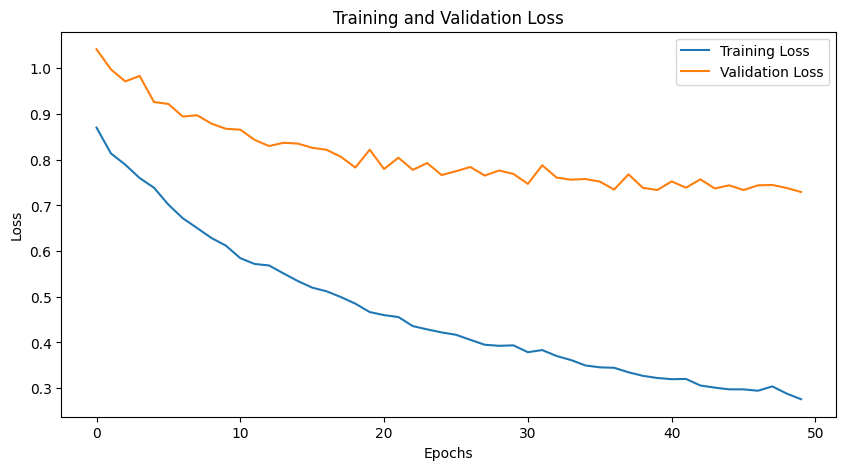

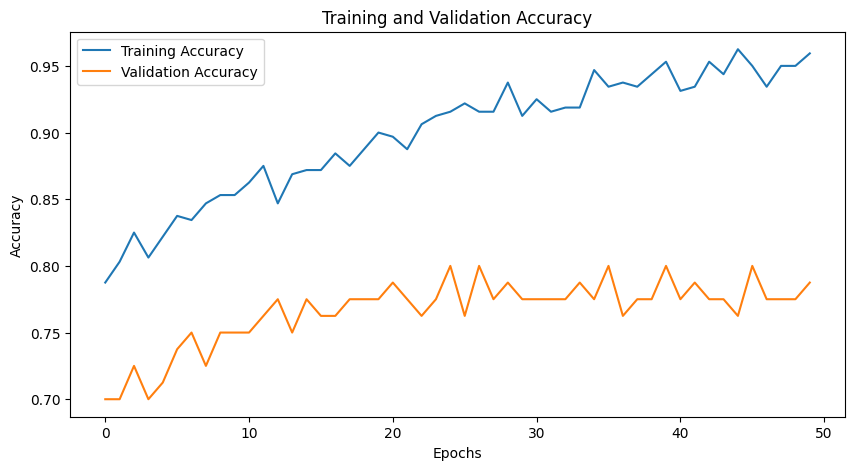

In [11]:
import matplotlib.pyplot as plt

# Plotting the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting the training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

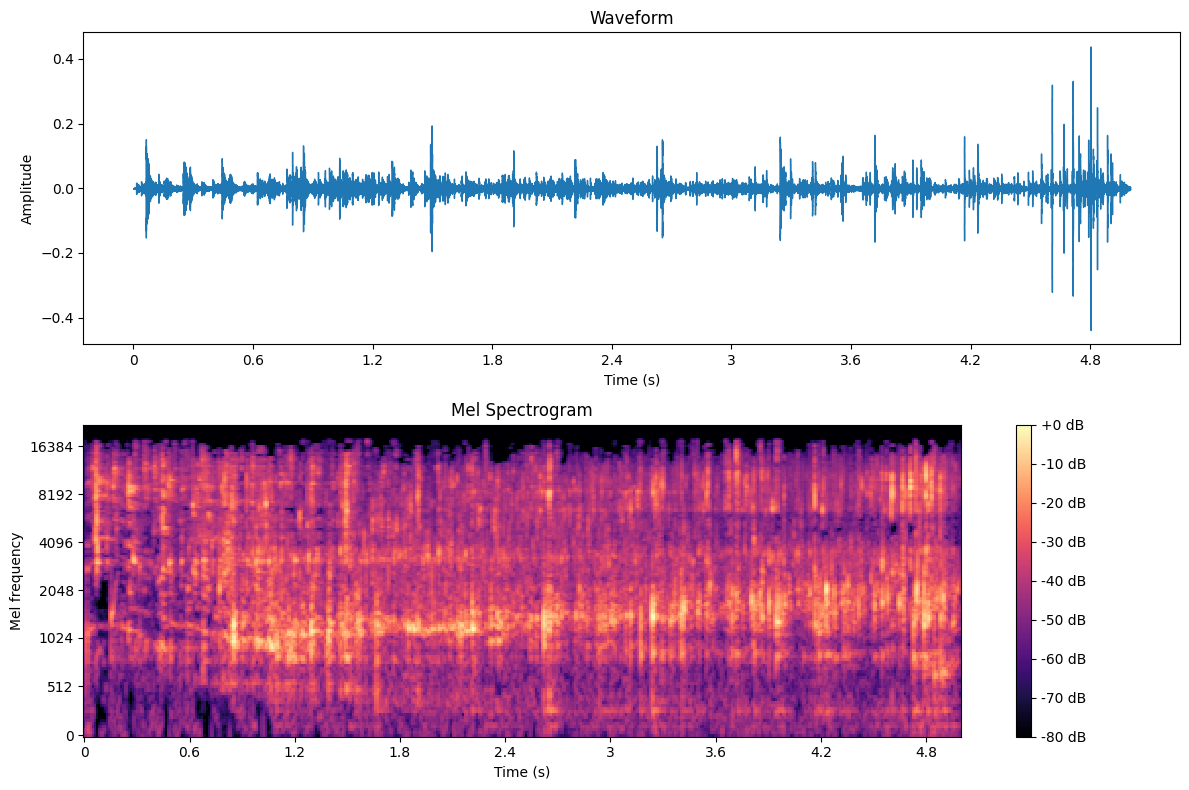

In [12]:
import random
import librosa.display
import matplotlib.pyplot as plt

def plot_audio(audio_path):
    # Load audio file
    y, sr = librosa.load(audio_path, sr=None)

    # Plot the waveform
    plt.figure(figsize=(12, 8))

    plt.subplot(2, 1, 1)
    librosa.display.waveshow(y, sr=sr)
    plt.title('Waveform')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')

    # Compute and plot the Mel Spectrogram
    plt.subplot(2, 1, 2)
    mels = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    S_DB = librosa.power_to_db(mels, ref=np.max)
    img = librosa.display.specshow(S_DB, sr=sr, x_axis='time', y_axis='mel')
    plt.title('Mel Spectrogram')
    plt.colorbar(img, format='%+2.0f dB')
    plt.xlabel('Time (s)')
    plt.ylabel('Mel frequency')

    plt.tight_layout()
    plt.show()

# Choose a random audio file from the dataset
audio_dir = './dataset/ESC-50-master/audio'
audio_files = [os.path.join(audio_dir, file) for file in os.listdir(audio_dir)]
random_audio_path = random.choice(audio_files)

# Call the function to plot the selected audio file
plot_audio(random_audio_path)